# Main steps in ML
- Data collection
- Data Preprocessing
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Model Training
- Model Evaluation
- Hyperparameter Tuning

## Download libraries and dataset

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

In [15]:
tesla_data = yf.download('TSLA', period="max")
tesla_data.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-03-19,235.860001,241.410004,229.199997,231.610001,111993800
2025-03-20,236.259995,238.000000,230.050003,233.350006,99028300
2025-03-21,248.710007,249.520004,234.550003,234.990005,132728700
2025-03-24,278.390015,278.640015,256.329987,258.079987,169079900
2025-03-25,288.140015,288.200012,271.279999,283.600006,149151000


## Preprocess Data
- handle missing data
- categorical encoding (one-hot, ordinal, nominal)
- feature scaling


In [16]:
tesla_data

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...
2025-03-19,235.860001,241.410004,229.199997,231.610001,111993800
2025-03-20,236.259995,238.000000,230.050003,233.350006,99028300


In [19]:
# LSTM need sequence length
sequence_length = 90

# extract target variable to predict
tesla_df = tesla_data[['Close']].copy()

# scale the data to improve model performance when handling too large values or too small values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(tesla_df)

# LSTM work by processing sequences of data
# Create sequences of data for training
# e.g. [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55
# X = [ [0.1 0.15 0.2], [0.15 0.2 0.25], ...]
# y = [ 0.25 0.3 ]
X, y = [], [] # input seq, target values
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length])

X, y = np.array(X), np.array(y)

## Split to Train & Test Sets

In [20]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2894, 90, 1)
X_test shape: (724, 90, 1)
y_train shape: (2894, 1)
y_test shape: (724, 1)


## Build Model
- perform model training
- LSTM parameters (https://keras.io/api/layers/recurrent_layers/lstm/)

In [22]:
# feed a sequence of 30 previous stock prices
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),  
    LSTM(32, return_sequences=False),  
    Dense(16, activation='relu'),  
    Dense(1)
])


lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
print(lstm_model.summary)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = lstm_model.fit(X_train, y_train,
               epochs=100,
               batch_size=16,
               validation_data=(X_test, y_test),
               callbacks=[early_stopping],
               verbose=1)

<bound method Model.summary of <Sequential name=sequential_2, built=True>>
Epoch 1/100


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 5.7620e-04 - mean_squared_error: 5.7620e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.2796e-04 - mean_squared_error: 3.2796e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.8296e-04 - mean_squared_error: 3.8296e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.3527e-04 - mean_squared_error: 3.3527e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.7453e-04 - mean_squared_error: 2.7453e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.3801e-04

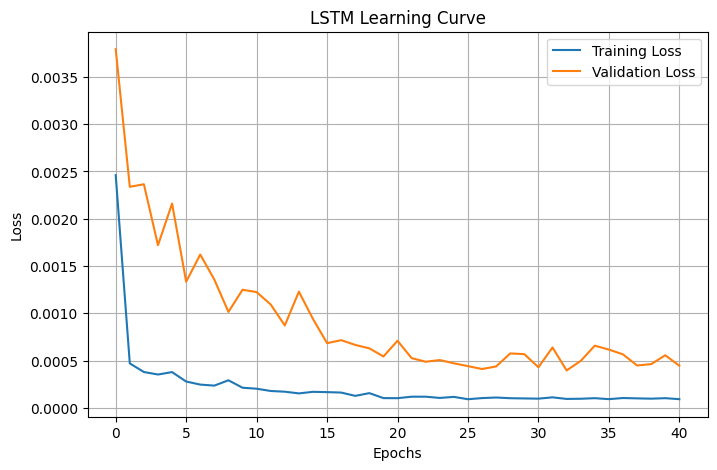

In [23]:
# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [24]:
# save model
lstm_model.save('tesla_stock_lstm_v2.h5')

In [25]:
# load model
from tensorflow.keras.models import load_model
loaded_model = load_model('tesla_stock_lstm_v2.h5')

### Model Evaluation

In [26]:
# Make predictions
test_predictions = loaded_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual, test_predictions)
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100
print(f'Mean Absolute Error (MAE): {mae: .2f}')
print(f'Mean Squared Error (MSE): {mse: .2f}')
print(f'Root Mean Squared Error (RMSE): {rmse: .2f}')
print(f"Mean Absolute Percentage Error (MAPE): {mape: .2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean Absolute Error (MAE):  6.80
Mean Squared Error (MSE):  90.87
Root Mean Squared Error (RMSE):  9.53
Mean Absolute Percentage Error (MAPE):  2.90%


## Future Predictions

In [27]:
def future_predictions():
    # Prepare data for future prediction
    last_sequence = tesla_data['Close'].values[-sequence_length:]
    last_sequence = scaler.transform(last_sequence.reshape(-1, 1)).flatten()

    days_to_predict = 15
    future_predictions = []
    current_sequence = last_sequence.copy()

    # Predict future prices
    print("Predicting future prices...")

    for _ in range(days_to_predict):
        # Reshape for prediction
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], 1)
        # Get next predicted value
        next_pred = loaded_model.predict(current_sequence_reshaped, verbose=1)
        # Append to predictions
        future_predictions.append(next_pred[0, 0])
        # Update sequence
        current_sequence = np.append(current_sequence[1:], next_pred)

    # Inverse transform to get actual price values
    future_predictions_array = np.array(future_predictions).reshape(-1, 1)
    future_pred = scaler.inverse_transform(future_predictions_array)

    # Create dates for future predictions
    last_date = tesla_data.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(len(future_pred))]

    # Create a DataFrame for the predictions
    forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Close': future_pred.flatten()
    })
    forecast_df.set_index('Date', inplace=True)

    print("\nTesla (TSLA) 30-Day Forecast:")
    for date, price in zip(forecast_df.index, forecast_df['Predicted_Close']):
        print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

    # Calculate predicted percent change
    initial_price = tesla_data['Close'].iloc[-1]  # Using iloc to get a scalar value
    for i, price in enumerate(forecast_df['Predicted_Close']):
        percent_change = ((price - initial_price) / initial_price) * 100
        print(f"Day {i+1} change from current price: {float(percent_change):.2f}%")

    return forecast_df

forecast_df = future_predictions()

Predicting future prices...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Tesla (TSLA) 30-Day Forecast:
2025-03-26: $288.46
2025-03-27: $290.41
2025-03-28: $292.96
2025-03-29: $295.48
2025-03-30: $297.60
2025-03-31: $299.22
2025-04-01: $300.36
2025-04-02: $301.12
2025-04-03: $301.60
2025-04-04: $301.87
2025-04-05: $302.00
2025-04-06: $302.04
2025-04-07: $302.02
2025-04-08: $301.96
2025-04-09: $301.88
Day 1 change from current price: 0.11%
Day 2 change from current price:

C:\Users\USER\AppData\Local\Temp\ipykernel_23816\3071967772.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Day {i+1} change from current price: {float(percent_change):.2f}%")


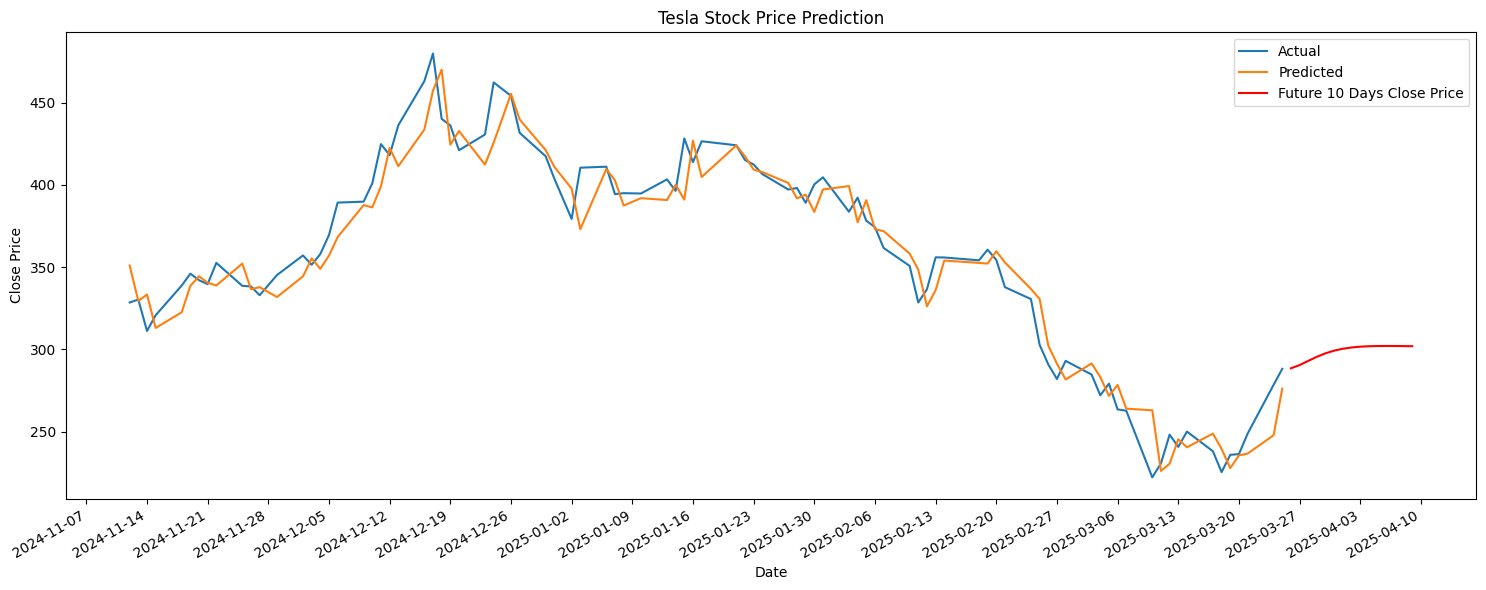

In [28]:
# Get the dates corresponding to the test data
test_dates = tesla_data.index[len(X_train) + sequence_length:]  # Adjust index if needed
y_test_actual = scaler.inverse_transform(y_test)

# Plot the actual and predicted values against dates
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-90:], y_test_actual[-90:], label='Actual')
plt.plot(test_dates[-90:], test_predictions[-90:], label='Predicted')
plt.plot(forecast_df.index[-90:], forecast_df['Predicted_Close'][-90:], 'r-', label='Future 10 Days Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Prediction')
plt.legend()

# Format x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Hyperparameter Fine-tuning

In [29]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2894, 90, 1)
X_test shape: (724, 90, 1)
y_train shape: (2894, 1)
y_test shape: (724, 1)


In [30]:
base_model = loaded_model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  4


In [49]:
# Fine-tune from this layer onwards
fine_tune_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [50]:
def build_model(hp):
    # Define hyperparameters for optimizer and learning rate
    hp_optimizers = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Map string names to actual optimizer classes
    optimizer_classes = {
        'sgd': optimizers.SGD,
        'rmsprop': optimizers.RMSprop,
        'adagrad': optimizers.Adagrad,
        'adadelta': optimizers.Adadelta,
        'adamax': optimizers.Adamax
    }

    # Get the actual optimizer class
    optimizer_class = optimizer_classes[hp_optimizers]

    # Compile the model with selected hyperparameters
    base_model.compile(optimizer=optimizer_class(learning_rate=hp_learning_rate),
                       loss='mean_squared_error',
                       metrics=['mean_squared_error'])

    return base_model


In [51]:
import keras_tuner
tuner = keras_tuner.GridSearch(
    build_model,
    objective='mean_squared_error',
    max_trials=15,
    executions_per_trial=1,
    directory='tuning',
    project_name='stock_prediction',
    max_consecutive_failed_trials=20
)
tuner.search_space_summary()

Reloading Tuner from tuning\stock_prediction\tuner0.json
Search space summary
Default search space size: 2
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [52]:
# Perform the hyperparameter search
tuner.search((X_train, y_train), epochs=10, validation_data=(X_test, y_test))

In [53]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Extract the best hyperparameters
best_optimizer = best_hps.get('optimizer')
best_learning_rate = best_hps.get('learning_rate')
print('Best optimizer: ',best_optimizer)
print('Best learning rate: ',best_learning_rate)

Best optimizer:  sgd
Best learning rate:  0.01


In [54]:
#  Map optimizer string to actual optimizer class
optimizer_classes = {
    'sgd': optimizers.SGD,
    'rmsprop': optimizers.RMSprop,
    'adagrad': optimizers.Adagrad,
    'adadelta': optimizers.Adadelta,
    'adamax': optimizers.Adamax
}
best_optimizer_class = optimizer_classes[best_optimizer]

# Build the model using the best hyperparameters
# it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
base_model.compile(optimizer=best_optimizer_class(learning_rate=best_learning_rate),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
base_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 90, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 29,857 (116.63 KB)

In [55]:
fine_tune_epochs = 50
total_epochs =  len(history.epoch) + fine_tune_epochs

history_fine = lstm_model.fit(X_train, y_train,
               epochs=total_epochs,
               initial_epoch=len(history.epoch),
               validation_data=(X_test, y_test),
               callbacks=[early_stopping],
               verbose=1)

Epoch 42/91
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.9477e-05 - mean_squared_error: 7.9477e-05 - val_loss: 4.5629e-04 - val_mean_squared_error: 4.5629e-04
Epoch 43/91
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.0854e-05 - mean_squared_error: 7.0854e-05 - val_loss: 4.0332e-04 - val_mean_squared_error: 4.0332e-04
Epoch 44/91
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.8913e-05 - mean_squared_error: 8.8913e-05 - val_loss: 4.2953e-04 - val_mean_squared_error: 4.2953e-04
Epoch 45/91
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.6447e-05 - mean_squared_error: 8.6447e-05 - val_loss: 4.0934e-04 - val_mean_squared_error: 4.0934e-04
Epoch 46/91
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.0566e-05 - mean_squared_error: 8.0566e-05 - val_loss: 3.9595e-04 - val_mean_squared_error: 3.9595e-04
Epoch 47/91
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.2052e-05 - mean_squared_error: 8.2052e-05 - val_loss: 6.2438e-04 - val_mean_squared_error: 6.2438e-04
Epoch 48/91
91/9

In [57]:
def plot_history2(history: object, history2: object):
    epochs_range = range(1, len(history.history['loss'])+len(history2.history['loss'])+1)
    plt.figure(num='Training Result', figsize=(12, 6))

    loss = history.history['loss'] + history2.history['loss']
    val_loss = history.history['val_loss'] + history2.history['val_loss']

    # Subchart 2
    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range,
             val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot([len(history.history['loss']),len(history.history['loss'])-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    # Space adjustments
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    plt.show()

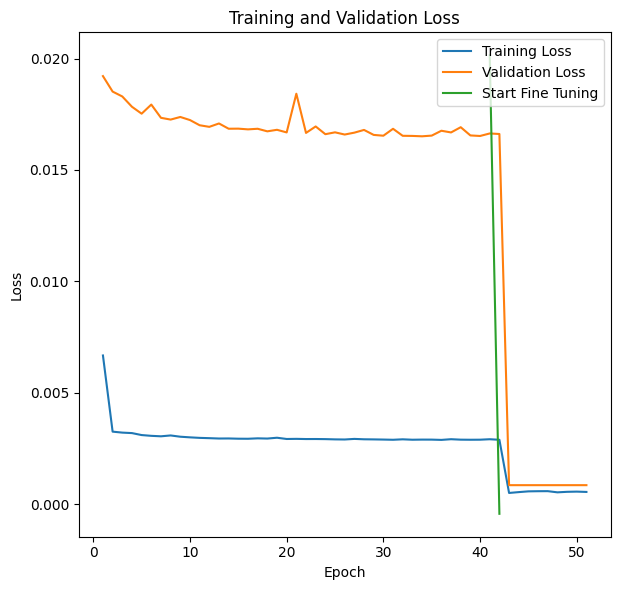

In [206]:
plot_history2(history,history_fine)

In [58]:
# Make predictions
test_predictions2 = lstm_model.predict(X_test)
test_predictions2 = scaler.inverse_transform(test_predictions2)
y_test_actual2 = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual2, test_predictions2)
mse = mean_squared_error(y_test_actual2, test_predictions2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual2 - test_predictions2) / y_test_actual2)) * 100
print(f'Mean Absolute Error (MAE): {mae: .2f}')
print(f'Mean Squared Error (MSE): {mse: .2f}')
print(f'Root Mean Squared Error (RMSE): {rmse: .2f}')
print(f"Mean Absolute Percentage Error (MAPE): {mape: .2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Mean Absolute Error (MAE):  6.78
Mean Squared Error (MSE):  90.77
Root Mean Squared Error (RMSE):  9.53
Mean Absolute Percentage Error (MAPE):  2.89%


In [59]:
forecast_df2 = future_predictions()

Predicting future prices...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Tesla (TSLA) 30-Day Forecast:
2025-03-26: $288.46
2025-03-27: $290.41
2025-03-28: $292.96
2025-03-29: $295.48
2025-03-30: $297.60
2025-03-31: $299.22
2025-04-01: $300.36
2025-04-02: $301.12
2025-04-03: $301.60
2025-04-04: $301.87
2025-04-05: $302.00
2025-04-06: $302.04
2025-04-07: $302.02
2025-04-08: $301.96
2025-04-09: $301.88
Day 1 change from current price: 0.11%
Day 2 change from current price

C:\Users\USER\AppData\Local\Temp\ipykernel_23816\3071967772.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Day {i+1} change from current price: {float(percent_change):.2f}%")


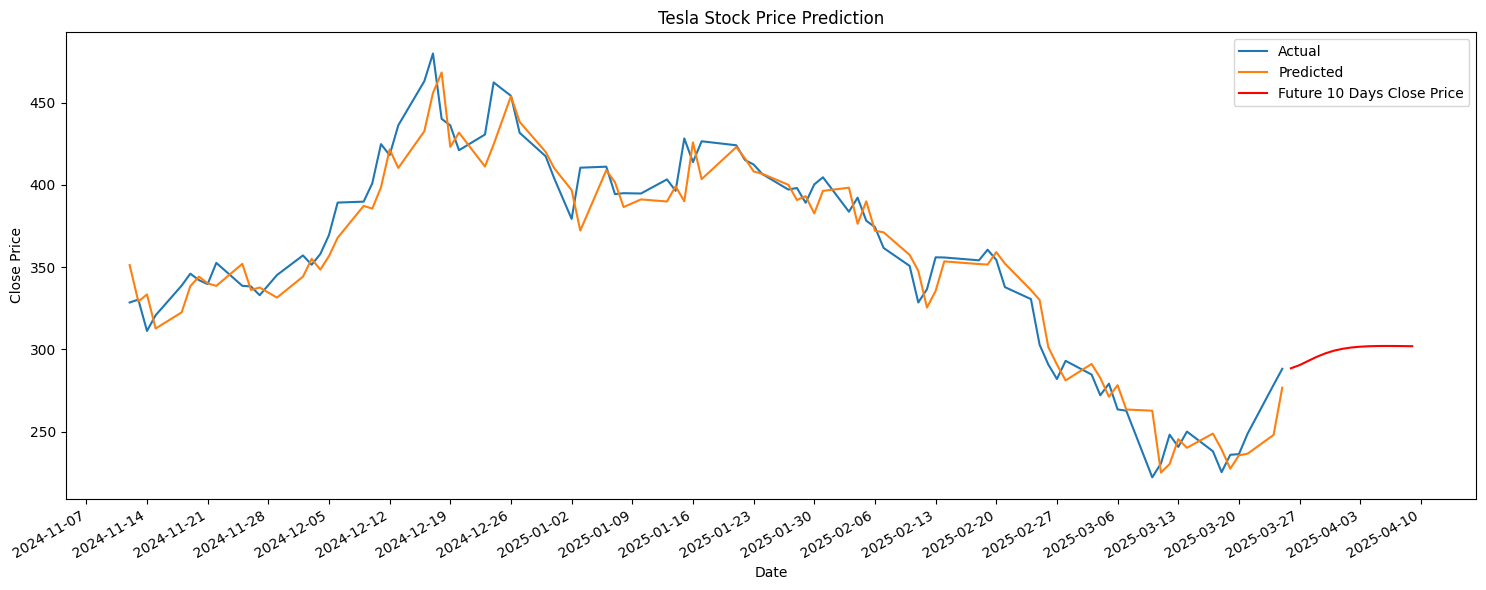

In [60]:
# Get the dates corresponding to the test data
test_dates2 = tesla_data.index[len(X_train) + sequence_length:]  # Adjust index if needed
y_test_actual2 = scaler.inverse_transform(y_test)

# Plot the actual and predicted values against dates
plt.figure(figsize=(15, 6))
plt.plot(test_dates2[-90:], y_test_actual2[-90:], label='Actual')
plt.plot(test_dates2[-90:], test_predictions2[-90:], label='Predicted')
plt.plot(forecast_df2.index[-90:], forecast_df2['Predicted_Close'][-90:], 'r-', label='Future 10 Days Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Prediction')
plt.legend()

# Format x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [61]:
##Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Features (X) and Target (y)
X = tesla_data[['Open', 'High', 'Low', 'Volume']]  # Input features
y = tesla_data['Close']  # Target: Closing price

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict future prices
y_pred = lr_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Baseline Linear Regression MAE: {mae:.2f}")
print(f"Baseline Linear Regression RMSE: {rmse:.2f}")
print(f"Baseline Model MAPE: {mape:.2f}%")


Baseline Linear Regression MAE: 0.79
Baseline Linear Regression RMSE: 1.73
Baseline Model MAPE: 1.34%


In [62]:
y_pred = pd.DataFrame(y_pred)
y_pred.index = X_test.index
# Convert index to datetime if not already
X_test.index = pd.to_datetime(X_test.index)

# Sort by date to get a proper line plot
X_test = X_test.sort_index()

# Convert y_test index to datetime if it's not already
y_test.index = pd.to_datetime(y_test.index)

# Ensure both X_test and y_test are sorted by index
y_test = y_test.sort_index()

# Now try to access y_test using X_test index
y_test_filtered = y_test.loc[X_test.index]


X_test.index = pd.to_datetime(X_test.index)

# Sort by date to get a proper line plot
y_pred = y_pred.sort_index()
y_pred_filtered = y_pred.loc[X_test.index]

In [63]:
results = pd.DataFrame({
    'Date' : X_test.index,
    'Actual_Close': y_test_filtered.values.flatten(),
    'Predicted_Close': y_pred_filtered.values.flatten()
})
# results = results.set_index(X_test.index)

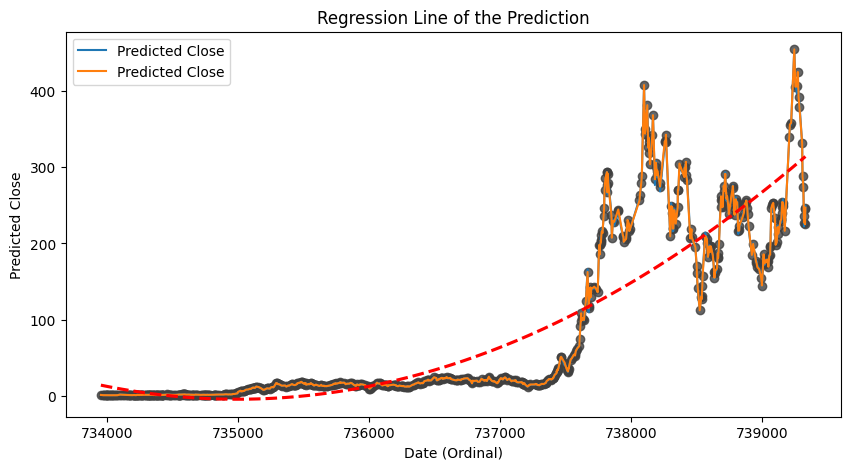

In [64]:
#plotting the Scatter plot to check relationship between Sal and Temp 
results['Date_ordinal'] = results['Date'].map(pd.Timestamp.toordinal)

# Create figure and axis
fig, axes = plt.subplots(figsize=(10, 5))

# Plot actual data (gray line)
axes.plot(results['Date_ordinal'], results['Actual_Close'], label="Predicted Close")
axes.plot(results['Date_ordinal'], results['Predicted_Close'], label="Predicted Close")

# Overlay regression plot
sns.regplot(
    x="Date_ordinal", 
    y="Predicted_Close", 
    data=results, 
    order=2,  # Polynomial regression of degree 2
    ci=None, 
    scatter_kws={'color': '0.25'}, 
    line_kws={'color': 'red', 'linestyle': '--'},
    ax=axes
)

# Set title and labels
axes.set_title('Regression Line of the Prediction')
axes.set_xlabel('Date (Ordinal)')
axes.set_ylabel('Predicted Close')

plt.legend()
plt.show()

In [65]:
# Get the latest 15 days of closing prices
tesla_data_copy = tesla_data.copy()
tesla_data_copy = tesla_data_copy.drop(columns=['Close'])
latest_data = tesla_data[['Close']].tail(5).values.flatten()

# Predict the next 15 days
future_prices = []
for i in range(15):
    # Reshape latest data to match the model's expected input shape
    input_data = np.array(latest_data[-4:]).reshape(1, -1)  # (1, 5) shape
    predicted_price = lr_model.predict(input_data)[0]  # Predict
    future_prices.append(predicted_price)  # Store prediction

    # Update latest_data with the new prediction (rolling window)
    latest_data = np.append(latest_data, predicted_price)

# Create future dates
from datetime import datetime, timedelta

last_date = tesla_data_copy.index[-1]  # Last available date
future_dates = [last_date + timedelta(days=i+1) for i in range(15)]

# Convert predictions into a DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_prices})
forecast_df.set_index('Date', inplace=True)

print("\nTesla (TSLA) 5-Day Forecast Using Linear Regression:")
for date, price in zip(forecast_df.index, forecast_df['Predicted_Close']):
    # Ensure price is a float before formatting
    print(f"{date.strftime('%Y-%m-%d')}: ${float(price):.2f}")



Tesla (TSLA) 5-Day Forecast Using Linear Regression:
2025-03-26: $280.37
2025-03-27: $304.91
2025-03-28: $288.04
2025-03-29: $295.16
2025-03-30: $306.83
2025-03-31: $283.12
2025-04-01: $309.02
2025-04-02: $295.15
2025-04-03: $288.96
2025-04-04: $314.20
2025-04-05: $281.43
2025-04-06: $305.31
2025-04-07: $303.80
2025-04-08: $279.95
2025-04-09: $319.15


C:\Users\USER\AppData\Local\Temp\ipykernel_23816\3274656446.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{date.strftime('%Y-%m-%d')}: ${float(price):.2f}")


In [66]:
connect_df = pd.DataFrame()
connect_df['Predicted_Close'] = results[-1:]['Predicted_Close']
connect_df.index = results[-1:]['Date']
connect_df=pd.concat([connect_df, forecast_df[:1]])


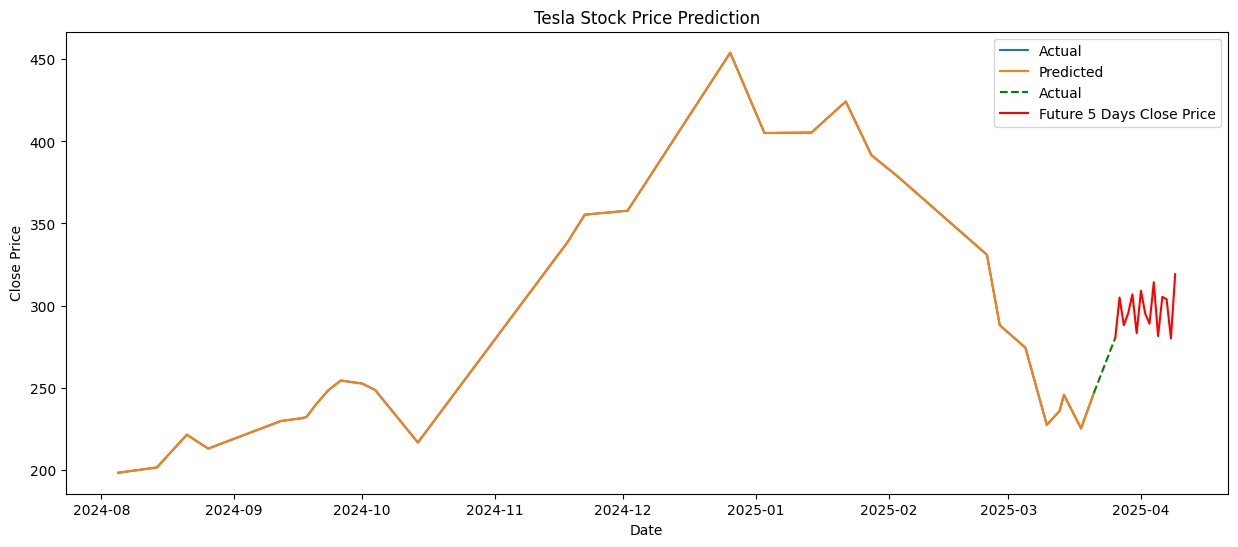

In [67]:
# Get the dates corresponding to the test data
# test_dates = tesla_data.index[len(X_train) + sequence_length:]  # Adjust index if needed

# Plot the actual and predicted values against dates
plt.figure(figsize=(15, 6))
plt.plot(X_test.index[-30:], results['Predicted_Close'][-30:], label='Actual')
plt.plot(X_test.index[-30:], results['Predicted_Close'][-30:], label='Predicted')
plt.plot(connect_df.index, connect_df['Predicted_Close'], 'g--', label='Actual')
plt.plot(forecast_df.index, forecast_df['Predicted_Close'], 'r-', label='Future 5 Days Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Prediction')
plt.legend()
plt.show()

In [68]:
from sklearn.ensemble import RandomForestRegressor

# Features (X) and Target (y)
X = tesla_data[['Open', 'High', 'Low', 'Volume']]
y = tesla_data['Close']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # ✅ Corrected

print(f"Random Forest MAE: {mae:.2f}")
print(f"Random Forest RMSE: {rmse:.2f}")

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest MAE: 0.99
Random Forest RMSE: 2.30


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [69]:
y_pred = pd.DataFrame(y_pred)
y_pred.index = X_test.index
# Convert index to datetime if not already
X_test.index = pd.to_datetime(X_test.index)

# Sort by date to get a proper line plot
X_test = X_test.sort_index()

# Convert y_test index to datetime if it's not already
y_test.index = pd.to_datetime(y_test.index)

# Ensure both X_test and y_test are sorted by index
y_test = y_test.sort_index()

# Now try to access y_test using X_test index
y_test_filtered = y_test.loc[X_test.index]


X_test.index = pd.to_datetime(X_test.index)

# Sort by date to get a proper line plot
y_pred = y_pred.sort_index()
y_pred_filtered = y_pred.loc[X_test.index]

In [70]:
# Get the latest 15 days of closing prices
tesla_data_copy = tesla_data.copy()
tesla_data_copy = tesla_data_copy.drop(columns=['Close'])
latest_data = tesla_data[['Close']].tail(5).values.flatten()

# Predict the next 15 days
future_prices = []
for i in range(15):
    # Reshape latest data to match the model's expected input shape
    input_data = np.array(latest_data[-4:]).reshape(1, -1)  # (1, 5) shape
    predicted_price = rf_model.predict(input_data)[0]  # Predict
    future_prices.append(predicted_price)  # Store prediction

    # Update latest_data with the new prediction (rolling window)
    latest_data = np.append(latest_data, predicted_price)

# Create future dates
from datetime import datetime, timedelta

last_date = tesla_data_copy.index[-1]  # Last available date
future_dates = [last_date + timedelta(days=i+1) for i in range(15)]

# Convert predictions into a DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_prices})
forecast_df.set_index('Date', inplace=True)

print("\nTesla (TSLA) 5-Day Forecast Using Linear Regression:")
for date, price in zip(forecast_df.index, forecast_df['Predicted_Close']):
    # Ensure price is a float before formatting
    print(f"{date.strftime('%Y-%m-%d')}: ${float(price):.2f}")



Tesla (TSLA) 5-Day Forecast Using Linear Regression:
2025-03-26: $269.02
2025-03-27: $278.08
2025-03-28: $280.06
2025-03-29: $275.28
2025-03-30: $277.67
2025-03-31: $277.82
2025-04-01: $276.36
2025-04-02: $277.52
2025-04-03: $277.80
2025-04-04: $276.86
2025-04-05: $277.05
2025-04-06: $277.71
2025-04-07: $276.78
2025-04-08: $276.47
2025-04-09: $277.59


In [71]:
connect_df = pd.DataFrame()
connect_df['Predicted_Close'] = results[-1:]['Predicted_Close']
connect_df.index = results[-1:]['Date']
connect_df=pd.concat([connect_df, forecast_df[:1]])


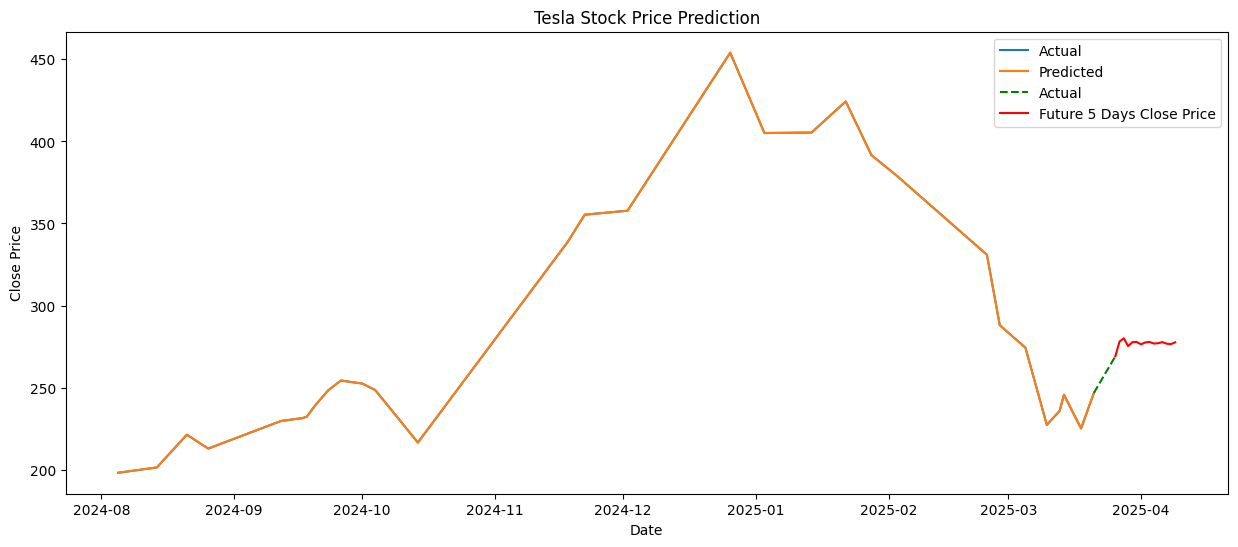

In [72]:
# Get the dates corresponding to the test data
# test_dates = tesla_data.index[len(X_train) + sequence_length:]  # Adjust index if needed

# Plot the actual and predicted values against dates
plt.figure(figsize=(15, 6))
plt.plot(X_test.index[-30:], results['Predicted_Close'][-30:], label='Actual')
plt.plot(X_test.index[-30:], results['Predicted_Close'][-30:], label='Predicted')
plt.plot(connect_df.index, connect_df['Predicted_Close'], 'g--', label='Actual')
plt.plot(forecast_df.index, forecast_df['Predicted_Close'], 'r-', label='Future 5 Days Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Prediction')
plt.legend()
plt.show()